In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import scipy.stats as st
from scipy.stats import binned_statistic
from gtex import *

In [2]:
working_dir = "/Users/filippo/Developer/tesi/gtex/"
os.chdir(working_dir)

In [3]:
normalisation_str='counts'

In [4]:
df_genes = pd.read_csv("../genes.txt", index_col=[0])
genes = df_genes[df_genes['type_of_gene'].isin(['intergenic', 'protein-coding', 'ncRNA', 'snRNA',
       'pseudo', 'antisense', 'microRNA', 'snoRNA', 'rRNA', 'scRNA'])].index.values
df_genes['type_of_gene'].unique()

array(['intergenic', 'unknown', 'protein-coding', 'ncRNA', 'snRNA',
       'pseudo', 'antisense', 'microRNA', 'snoRNA', 'rRNA', 'scRNA'],
      dtype=object)

In [5]:
# GTEX
common_tissues = ['Blood','Heart', 'Muscle', 'Brain', 'Skin', 'Adipose Tissue', 'Nerve', 'Thyroid', 'Testis']
more_common_tissues = np.unique(samples['primary_site'])

In [6]:
samples = pd.read_csv("files.dat", index_col=[0])
samples.head()

,primary_site,secondary_site
GTEX-1117F-0226-SM-5GZZ7,Adipose Tissue,Adipose - Subcutaneous
GTEX-111CU-1826-SM-5GZYN,Adipose Tissue,Adipose - Subcutaneous
GTEX-111FC-0226-SM-5N9B8,Adipose Tissue,Adipose - Subcutaneous
GTEX-111VG-2326-SM-5N9BK,Adipose Tissue,Adipose - Subcutaneous
GTEX-111YS-2426-SM-5GZZQ,Adipose Tissue,Adipose - Subcutaneous


In [7]:
primaries = samples['primary_site'].unique()

In [8]:
np.sort(primaries)

array(['Adipose Tissue', 'Adrenal Gland', 'Bladder', 'Blood',
       'Blood Vessel', 'Brain', 'Breast', 'Cervix Uteri', 'Colon',
       'Esophagus', 'Fallopian Tube', 'Heart', 'Kidney', 'Liver', 'Lung',
       'Muscle', 'Nerve', 'Ovary', 'Pancreas', 'Pituitary', 'Prostate',
       'Salivary Gland', 'Skin', 'Small Intestine', 'Spleen', 'Stomach',
       'Testis', 'Thyroid', 'Uterus', 'Vagina'], dtype=object)

In [9]:
np.sort(np.unique(samples['secondary_site']))

array(['Adipose - Subcutaneous', 'Adipose - Visceral (Omentum)',
       'Adrenal Gland', 'Artery - Aorta', 'Artery - Coronary',
       'Artery - Tibial', 'Bladder', 'Brain - Amygdala',
       'Brain - Anterior cingulate cortex (BA24)',
       'Brain - Caudate (basal ganglia)', 'Brain - Cerebellar Hemisphere',
       'Brain - Cerebellum', 'Brain - Cortex',
       'Brain - Frontal Cortex (BA9)', 'Brain - Hippocampus',
       'Brain - Hypothalamus',
       'Brain - Nucleus accumbens (basal ganglia)',
       'Brain - Putamen (basal ganglia)',
       'Brain - Spinal cord (cervical c-1)', 'Brain - Substantia nigra',
       'Breast - Mammary Tissue', 'Cells - EBV-transformed lymphocytes',
       'Cells - Transformed fibroblasts', 'Cervix - Ectocervix',
       'Cervix - Endocervix', 'Colon - Sigmoid', 'Colon - Transverse',
       'Esophagus - Gastroesophageal Junction', 'Esophagus - Mucosa',
       'Esophagus - Muscularis', 'Fallopian Tube',
       'Heart - Atrial Appendage', 'Heart - Left Ven

In [47]:
# GTex
df = pd.read_csv("GTEx_Analysis_2016-01-15_v7_RNASeQCv1.1.8_gene_median_tpm.gct", index_col=[0], sep='\t')
df.drop('Description', axis=1, inplace=True)
df.index=[g[:15] for g in df.index.values]
df.fillna(value=0., inplace=True)
df.head()

,Adipose - Subcutaneous,Adipose - Visceral (Omentum),Adrenal Gland,Artery - Aorta,Artery - Coronary,Artery - Tibial,Bladder,Brain - Amygdala,Brain - Anterior cingulate cortex (BA24),Brain - Caudate (basal ganglia),...,Skin - Not Sun Exposed (Suprapubic),Skin - Sun Exposed (Lower leg),Small Intestine - Terminal Ileum,Spleen,Stomach,Testis,Thyroid,Uterus,Vagina,Whole Blood
ENSG00000223972,0.056945,0.05054,0.07460,0.03976,0.04386,0.04977,0.05878,0.089315,0.07901,0.075870,...,0.05417,0.05982,0.06089,0.070250,0.063895,1.76000,0.058350,0.03849,0.03386,0.11750
ENSG00000227232,11.850000,9.75300,8.02300,12.51000,12.30000,11.59000,14.24000,5.743000,6.81200,6.678500,...,17.15000,17.74000,12.19000,18.130000,9.342500,17.14000,19.255000,21.81000,17.28000,8.43900
ENSG00000243485,0.061460,0.05959,0.08179,0.04297,0.05848,0.05184,0.06097,0.115450,0.10860,0.087855,...,0.06487,0.06389,0.05562,0.049525,0.078575,0.07375,0.066845,0.00000,0.04732,0.00000
ENSG00000237613,0.038600,0.03245,0.04050,0.02815,0.03678,0.03894,0.04113,0.056265,0.05148,0.052990,...,0.03615,0.04080,0.03527,0.032320,0.043800,0.03714,0.038565,0.00000,0.00000,0.02574
ENSG00000268020,0.035695,0.00000,0.03479,0.00000,0.00000,0.00000,0.00000,0.050520,0.04744,0.039240,...,0.03034,0.03705,0.03375,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.00000


In [ ]:
#df.loc[:,'Description'].to_csv('gene_symbol.txt', index=True)

In [11]:
df = df[df.index.isin(df_genes[df_genes['type_of_gene']=='protein-coding'].index.values)]

## Tissue U

In [48]:
O = df.dropna().apply(lambda x: len(x[x!=0])/float(len(x)),axis=1)

/Users/filippo/anaconda3/envs/phd/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """
/Users/filippo/anaconda3/envs/phd/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


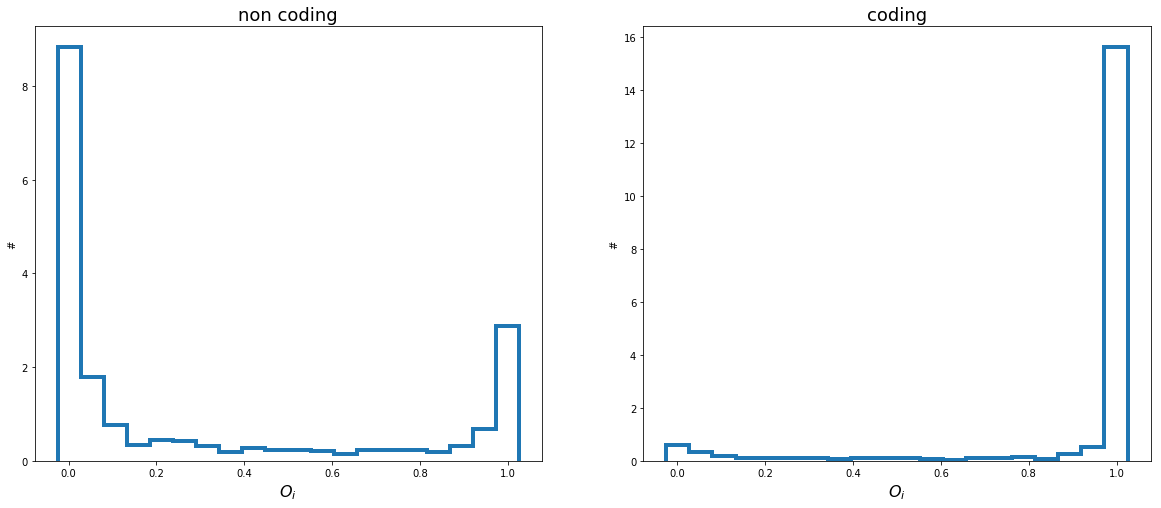

In [49]:
fig = plt.figure(figsize=(20,8))
ax = fig.subplots(1,2)
bins = 20
rang = (0-0.5/20,1+0.5/20)
ax[0].hist(np.array(O.loc[df_genes[df_genes['type_of_gene']!='protein-coding'].index.values].dropna().values,dtype=float), histtype='step', lw=4, density=True, bins=bins, range=rang)
ax[0].set_title("non coding", fontsize=18)
ax[0].set_xlabel('$O_i$', fontsize=16)
ax[0].set_ylabel('#')
ax[1].hist(np.array(O.loc[df_genes[df_genes['type_of_gene']=='protein-coding'].index.values].dropna().values,dtype=float), histtype='step', lw=4, density=True, bins=bins, range=rang)
ax[1].set_title("coding", fontsize=18)
ax[1].set_xlabel('$O_i$', fontsize=16)
ax[1].set_ylabel('#')
plt.show()
fig.savefig("U_tissue.pdf")

## average tissues

In [15]:
df_tissue = pd.DataFrame(index=df.index)
for tissue in primaries:
    print(tissue)
    #GTEX TPM
    df_tissue.insert(0,tissue,df.loc[:,get_specific_mapping_to(tissue)].dropna().mean(axis=1))
    #GTex counts 
    #df_tissue.insert(0,tissue,df.loc[:,samples[samples['primary_site']==tissue].index.values].dropna().mean(axis=1))
    #df_tissue.insert(0,tissue,df.loc[:,tissue].dropna())
df_tissue.head()

Adipose Tissue
Adrenal Gland
Blood Vessel
Bladder
Brain
Breast
Blood
Skin
Cervix Uteri
Colon
Esophagus
Fallopian Tube
Heart
Kidney
Liver
Lung
Salivary Gland
Muscle
Nerve
Ovary
Pancreas
Pituitary
Prostate
Small Intestine
Spleen
Stomach
Testis
Thyroid
Uterus
Vagina


,Vagina,Uterus,Thyroid,Testis,Stomach,Spleen,Small Intestine,Prostate,Pituitary,Pancreas,...,Colon,Cervix Uteri,Skin,Blood,Breast,Brain,Bladder,Blood Vessel,Adrenal Gland,Adipose Tissue
ENSG00000186092,0.000,0.0000,0.051925,0.03954,0.055415,0.040025,0.05122,0.046005,0.03887,0.028115,...,0.047720,0.07411,0.032630,0.015643,0.04728,0.077097,0.05461,0.029127,0.06136,0.048515
ENSG00000187634,8.808,14.9400,6.866000,9.60500,4.473000,25.155000,5.25400,22.780000,47.81000,1.051000,...,5.776750,9.22700,1.023100,0.085505,2.14450,1.752565,23.71000,6.921000,5.41650,2.250175
ENSG00000188976,71.170,77.3100,66.580000,99.06000,43.425000,60.760000,45.12000,63.835000,57.56000,30.500000,...,50.845000,70.55750,85.693333,54.975000,59.14000,37.422692,74.66000,56.980000,37.78500,51.187500
ENSG00000187961,18.450,18.1500,15.445000,32.19000,10.575000,22.945000,12.11000,17.920000,21.42000,4.893500,...,11.620000,19.89250,16.006667,10.036000,12.27000,9.255462,19.56000,12.806667,8.15550,9.659000
ENSG00000187583,46.570,0.7258,1.289500,1.34200,1.225000,2.138000,1.24700,5.933000,0.60110,0.644550,...,0.513975,1.22695,45.168667,1.284300,3.09600,0.142454,22.86000,0.784867,2.00150,0.624675


## integral

In [16]:
def get_integral_tissue(tissue):
    x = np.sort(df_tissue.loc[genes,tissue].fillna(0).values)[::-1]
    norm = np.sum(x)
    return np.cumsum(x/float(norm))

Blood
Heart
Muscle
Brain
Skin


/Users/filippo/anaconda3/envs/phd/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


Adipose Tissue
Nerve
Thyroid
Testis


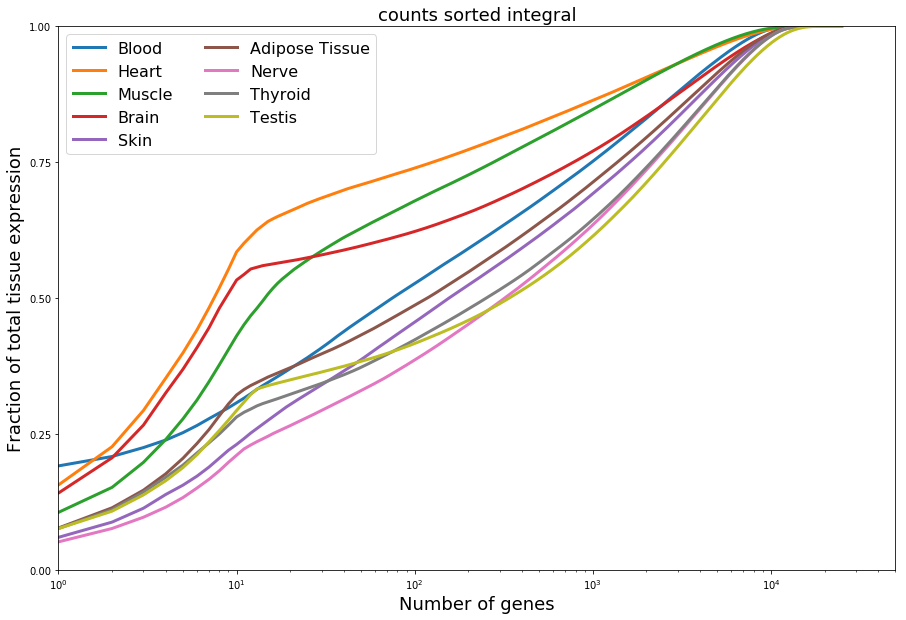

In [17]:
fig=plt.figure(figsize=(15,10))
ax=fig.subplots()
ax.set_title('%s sorted integral'%normalisation_str, fontsize=18)
for tissue in common_tissues:
#for tissue in more_common_tissues:
#for tissue in primaries:
        print(tissue)
        ax.plot(get_integral_tissue(tissue),label=tissue, lw=3)

#blood = df.loc[:,samples[samples['secondary_site']=='Whole Blood'].index.values].values
#ax.plot(np.cumsum(np.sort(blood)[::-1])/np.sum(blood), label='Whole Blood', lw=2)

ax.set_xscale('log')
ax.set_xlabel('Number of genes', fontsize=18)
ax.set_ylabel('Fraction of total tissue expression', fontsize=18)
ax.set_xlim((1,5e4))
ax.set_yticks([0,0.25,0.5,0.75,1])
ax.set_ylim(0,1)
plt.legend(ncol=2, fontsize=16)
plt.show()
fig.savefig("fraction_of_trascriptome.pdf")

In [ ]:
df.columns

In [ ]:
for ensg in df['Whole Blood'].sort_values(ascending=False)[:10].index.values:
    print(ensg)

In [ ]:
print(df_tissue['Brain'].sort_values(ascending=False)[:15])
x = df_tissue['Brain'].sort_values(ascending=False)
for g in df_tissue['Brain'].sort_values(ascending=False).index.values[:10]:
    print(g)

## Zipf & Heaps

## Zipf

In [22]:
variable_tissues = ['Heart','Brain','Nerve', 'Blood']

In [23]:
def get_zipf_tissue(tissue):
    '''
    return array zipf
    '''
    A = np.sort(df_tissue.loc[:,tissue].dropna().values)[::-1]
    A /= np.sum(A)
    return A

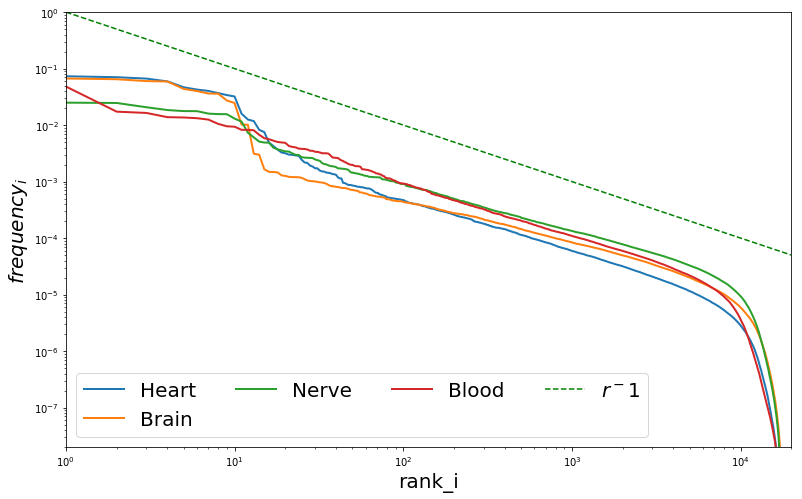

In [27]:
fig = plt.figure(figsize=(13,8))
for tissue in variable_tissues:
    plt.plot(get_zipf_tissue(tissue), lw=2, ls='-', label=tissue)
plt.plot(np.arange(1,2e4), 1./np.arange(1,2e4), 'g--', label='$r^-1$')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('rank_i', fontsize=20)
plt.ylabel('$frequency_i$', fontsize=20)
plt.xlim(1,2e4)
plt.ylim(2e-8,1e0)
plt.legend(ncol=4, fontsize=20)
plt.show()
fig.savefig("Zipf_tissue.pdf")

## Heaps

In [41]:
def get_heaps_tissue(tissue):
    subdf = df.loc[:,samples[samples['secondary_site'].isin(get_specific_mapping_to(tissue))].index.values]
    M = subdf.apply(lambda x: np.sum(x), axis=0).values
    ndw = subdf.apply(lambda x: len(np.nonzero(x)[0]), axis=0).values
    return M, ndw    

/Users/filippo/anaconda3/envs/phd/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return getattr(obj, method)(*args, **kwds)


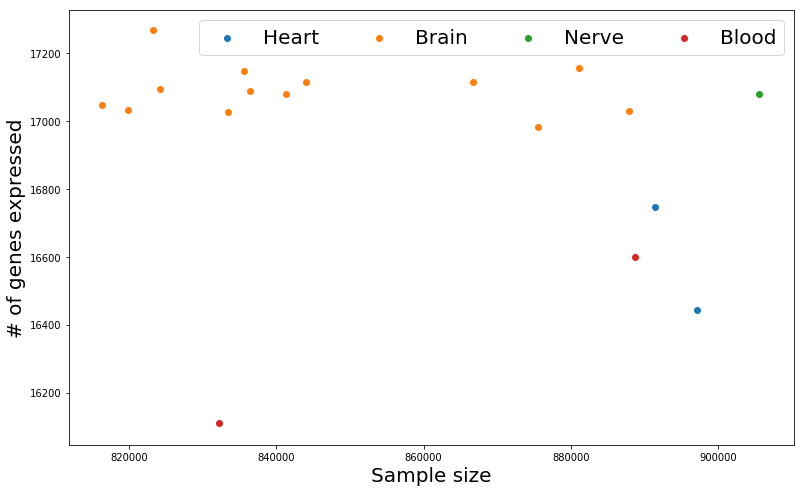

In [43]:
fig = plt.figure(figsize=(13,8))
for tissue in variable_tissues:
    heaps = get_heaps_tissue(tissue)
    plt.scatter(heaps[0], heaps[1],  label=tissue)
plt.xlabel('Sample size', fontsize=20)
plt.ylabel('# of genes expressed', fontsize=20)
plt.legend(ncol=4, fontsize=20)
plt.show()
fig.savefig("Heaps_tissue.pdf")

## global

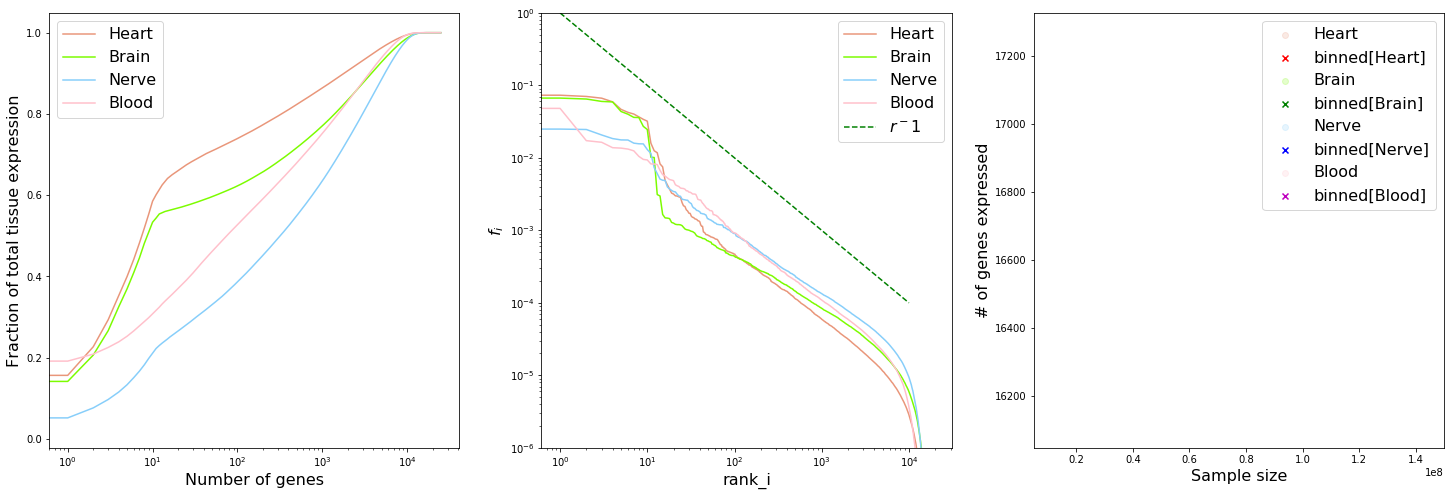

In [44]:
fig=plt.figure(figsize=(25,8))
ax = fig.subplots(1,3)
colors = (['darksalmon','lawngreen', 'lightskyblue','pink'],['r','g','b','m'])
variable_tissues = ['Heart','Brain','Nerve', 'Blood']
for i,tissue in enumerate(variable_tissues):
    ax[0].plot(get_integral_tissue(tissue), label=tissue, color=colors[0][i])
    ax[1].plot(get_zipf_tissue(tissue), label=tissue,color=colors[0][i])
    heaps = get_heaps_tissue(tissue)
    ax[2].scatter(heaps[0],heaps[1], label=tissue, c=colors[0][i], alpha=0.2)
    bin_means, bin_edges, _ = binned_statistic(heaps[0], heaps[1], bins = np.linspace(0.2e8,1.5e8))
    #bin_means, bin_edges, _ = binned_statistic(heaps[0], heaps[1], bins = np.linspace(8.6e5,9.8e5,8))
    ax[2].scatter((bin_edges[:-1]+bin_edges[1:])/2., bin_means, marker='x', c=colors[1][i], label='binned[%s]'%tissue)
    
ax[1].plot(np.arange(1,1e4), 1./np.arange(1,1e4), 'g--', label='$r^-1$')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[0].legend(fontsize=16)
ax[1].legend(fontsize=16)
ax[2].legend(fontsize=16)
ax[0].set_xlabel('Number of genes', fontsize=16)
ax[0].set_ylabel('Fraction of total tissue expression', fontsize=16)
ax[1].set_xlabel('rank_i', fontsize=16)
ax[1].set_ylabel('$f_i$', fontsize=16)
ax[2].set_xlabel('Sample size', fontsize=16)
ax[2].set_ylabel('# of genes expressed', fontsize=16)
ax[2].set_xlim(0.05e8,1.5e8)
ax[1].set_ylim(1e-6,1)
plt.show()
fig.savefig("zipfheaps_tissue.pdf")

# lenght

In [ ]:
q_many = pd.read_csv("genes.txt", index_col=[0], header=[0])
q_many = q_many[q_many['type_of_gene']=='protein-coding']
lenghts = q_many['lenght']

In [ ]:
#from scipy.stats import binned_statistic
fig=plt.figure(figsize=(15,7))
bins_for_l = np.logspace(1,8,40)
for tissue in primaries:
    bin_means, bin_edges, _ = binned_statistic(lenghts, df_tissue.loc[:,tissue], statistic='mean', bins=bins_for_l)
    #plt.scatter(lenghts,df_tissue.loc[:,tissue])
    plt.scatter((bin_edges[1:]+bin_edges[:-1])/2,bin_means, marker='x',label=tissue)
    plt.yscale('log')
    plt.xscale('log')
plt.xlabel('lenght (bp)', fontsize=16)
plt.ylabel('mean (counts)', fontsize=16)
plt.xlim((lenghts.min(),lenghts.max()))
plt.ylim((1e-3,1e5))
plt.legend(ncol=2)
plt.show()
fig.savefig("meanLenght_tissue.pdf")

## inter intra

In [ ]:
inter_vars = df_tissue.apply(np.var, axis=1).values
inter_means = df_tissue.apply(np.average, axis=1).values

In [ ]:
inter_cv2s = [inter_vars[i]/(m*m) if m>0 else 0 for i,m in enumerate(inter_means)]

In [ ]:
fig=plt.figure(figsize=(15,4))
plt.scatter(inter_means, inter_cv2s, c='b')
plt.plot(x_lin[:30],1./x_lin[:30], 'g-', lw=3.5, label='Poisson')
plt.plot(x_lin[-30:],[1 for _ in x_lin[-30:]], 'r-', lw=3.5, label='Taylor')
plt.plot(x_lin,[len(df_tissue.columns)-1 for _ in x_lin], '--', lw=3.5, label='bound')

bin_means, bin_edges,_=binned_statistic(inter_means, inter_cv2s, statistic='mean', bins=np.logspace(np.log10(np.min(inter_means[inter_means.nonzero()])),np.log10(np.max(inter_means))))

plt.scatter((bin_edges[1:]+bin_edges[:-1])/2, bin_means, marker='x', lw=2, color='orange')

plt.title('inter_tissue',fontsize=18)
plt.xlabel("$<%s>$"%normalisation_str, fontsize=16)
plt.ylabel("$cv^2$", fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlim(means[means.nonzero()].min()/5,np.power(10,np.log10(means.max())+1))
plt.ylim(variances[variances.nonzero()].min()/10,len(subdf.columns)*10)
plt.legend(fontsize=16)
plt.show()
fig.savefig("cvmean_loglog_inter_tissue.png")

In [ ]:
bin_means, bin_edges, binnumber = binned_statistic(inter_means, inter_cv2s, statistic='mean', bins=np.logspace(np.log10(np.min(inter_means[inter_means.nonzero()])),np.log10(np.max(inter_means))))

def get_inter_distance_from_mean(mean, cv2):
    bin_i = 0
    for i,_ in enumerate(bin_edges[:-1]):
        if mean<bin_edges[i+1] and mean > bin_edges[i]:
            bin_i = i
            break
    return(cv2-bin_means[bin_i])

In [ ]:
subdf = df.loc[:,samples[samples['primary_site']==tissue].index.values]
intra_means = subdf.apply(np.nanmean, axis=1).values
intra_variance = subdf.apply(np.nanvar, axis=1).values
intra_cv2 = [intra_variance[i]/(np.power(mean,2)) if mean>0 else 0 for i,mean in enumerate(intra_means) ]

bin_means_intra, bin_edges_intra, _ = binned_statistic(intra_means, intra_cv2, statistic='mean', bins=np.logspace(np.log10(np.min(intra_means[intra_means.nonzero()])),np.log10(np.max(intra_means))))

def get_intra_distance_from_mean(mean, cv2):
    bin_i = 0
    for i,_ in enumerate(bin_edges[:-1]):
        if mean<bin_edges_intra[i+1] and mean > bin_edges_intra[i]:
            bin_i = i
            break
    return(cv2-bin_means_intra[bin_i])

In [ ]:
inter = []
intra = []
for i,g in enumerate(df_tissue.index.values):
    inter.append(get_inter_distance_from_mean(inter_means[i],inter_cv2s[i]))
    intra.append(get_intra_distance_from_mean(intra_means[i], intra_cv2[i]))
intra=np.array(intra)
inter=np.array(inter)

In [ ]:
x = np.logspace(np.log10(5e-1),20)
fig = plt.figure()
plt.scatter(inter, intra, label=tissue)
#plt.plot(x,x)
#plt.plot(x,np.sqrt(x))
plt.xlabel('inter_(tissue+individual)')
plt.ylabel('intra_%s'%tissue)
#plt.yscale('log')
#plt.xscale('log')
plt.ylim(-50,150)
plt.xlim(-50,35)
plt.show()
fig.savefig("inter_intra_%s.png"%tissue)

In [ ]:
for i, inter_g in enumerate(inter):
    if((np.abs(intra[i])<1) & (inter_g<10 and inter_g>8)):
        print(df.index[i])